In [13]:
!pip install pyspark==3.5.2 nltk==3.9.\*


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [14]:
import nltk

nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)

%matplotlib inline

In [1]:
import os

print(os.environ["JAVA_HOME"])

/opt/homebrew/Cellar/openjdk@17/17.0.17/libexec/openjdk.jdk/Contents/Home


In [16]:
import os
from pyspark.sql import SparkSession

print("JAVA_HOME z env:", os.environ.get("JAVA_HOME"))

spark = (
    SparkSession.builder
    .master("local[*]")
    .appName("ScaleBenchmarkSparkPython_FairReplication")
    .config("spark.sql.shuffle.partitions", "10")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.driver.memory", "6g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

jvm = spark._jvm
print("Java z JVM:", jvm.java.lang.System.getProperty("java.version"))

spark.stop()

JAVA_HOME z env: /opt/homebrew/Cellar/openjdk@17/17.0.17/libexec/openjdk.jdk/Contents/Home
Java z JVM: 17.0.17



=== TEST: MULTIPLIER = 1 ===
Python: 0.25s | Spark: 0.73s

=== TEST: MULTIPLIER = 25 ===
Python: 0.88s | Spark: 0.51s

=== TEST: MULTIPLIER = 50 ===
Python: 1.55s | Spark: 0.56s

=== TEST: MULTIPLIER = 100 ===


Python: 2.80s | Spark: 0.76s

=== TEST: MULTIPLIER = 200 ===


Python: 5.62s | Spark: 1.45s

=== TEST: MULTIPLIER = 400 ===


Python: 10.74s | Spark: 2.84s

=== TEST: MULTIPLIER = 800 ===


Python: 21.57s | Spark: 5.61s


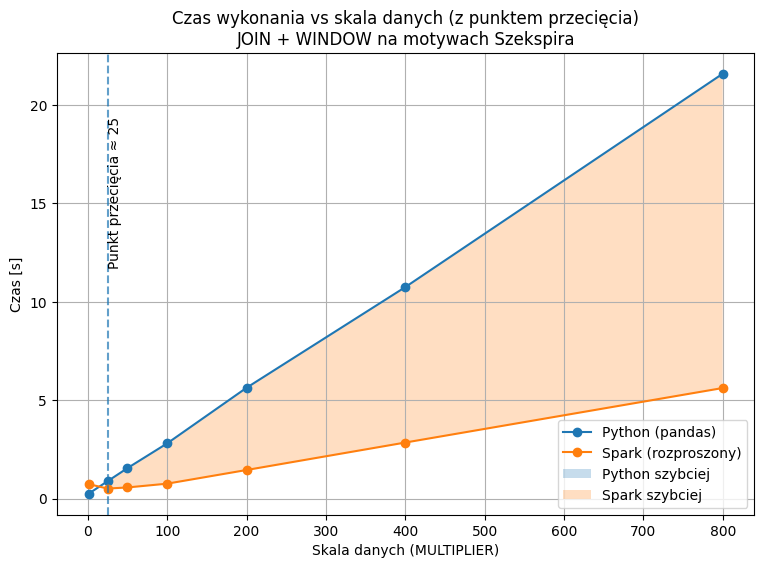

 Dydaktyczna interpretacja:
• Do MULTIPLIER ≈ 25 Python bywa szybszy (niższy narzut, praca w RAM).
• Powyżej tej wartości Spark wygrywa — równoległość + optymalizacja DAG.
• Replikacja w Sparku odbywa się PRZED block_id z przesunięciem indeksu, więc rośnie realna liczba bloków (uczciwa skala).
• Pomiar obejmuje tylko fazę okienkową (JOIN + WINDOW), bez transferu do drivera.


In [17]:
import re, time, urllib.request, ssl
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# ============================================================
# I Przygotowanie środowiska NLTK (tokenizer do wersji Python)
# ============================================================
import nltk
from nltk.tokenize import word_tokenize


def _ensure_nltk():
    """Pobiera wymagane zasoby NLTK, jeśli nie są zainstalowane."""
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt', quiet=True)
    try:
        nltk.data.find('tokenizers/punkt_tab')
    except LookupError:
        nltk.download('punkt_tab', quiet=True)


_ensure_nltk()

# ============================================================
# II Inicjalizacja sesji Spark
# ============================================================
from pyspark.sql import SparkSession, functions as F, Window

spark = (
    SparkSession.builder
    .master("local[*]")
    .appName("ScaleBenchmarkSparkPython_FairReplication")
    .config("spark.sql.shuffle.partitions", "10")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.driver.memory", "6g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")

# ============================================================
# III Przygotowanie danych wejściowych — sztuki Szekspira
# ============================================================
DATA_DIR = Path("./data_shakespeare")
DATA_DIR.mkdir(parents=True, exist_ok=True)

SOURCES = {
    "Hamlet": ("https://www.gutenberg.org/cache/epub/1524/pg1524.txt", DATA_DIR / "hamlet.txt"),
    "Macbeth": ("https://www.gutenberg.org/cache/epub/1533/pg1533.txt", DATA_DIR / "macbeth.txt"),
    "Romeo and Juliet": ("https://www.gutenberg.org/cache/epub/1513/pg1513.txt", DATA_DIR / "romeo_and_juliet.txt"),
}


def _dl(url, dest):
    """Pobiera plik z Gutenberga (bez walidacji SSL)."""
    if dest.exists(): return
    ctx = ssl.create_default_context();
    ctx.check_hostname = False;
    ctx.verify_mode = ssl.CERT_NONE
    urllib.request.urlretrieve(url, dest)


# pobranie trzech tekstów
for _, (u, p) in SOURCES.items():
    _dl(u, p)

# ============================================================
# IV Parametry eksperymentu
# ============================================================
KEYWORDS_1 = ["ghost", "sword", "death", "hamlet"]  # słowa-klucze do analizy do zmiany
KEYWORDS_2 = ["king", "blood", "kill", "love"]  # słowa-klucze do analizy do zmiany
BLOCK_SIZE = 150  # liczba tokenów na blok (okno)
BLOCK_SIZES = [150, 50, 500]
WINDOW_RADIUS = 2  # zasięg okna ruchomego
SCALES = [1, 25, 50, 100, 200, 400, 800]  # poziomy powielania danych


# ============================================================
# V Pomocnicze funkcje dla wersji Python (pandas)
# ============================================================
def clean_and_tokenize_py(txt: str):
    """Czyszczenie i tokenizacja tekstu w czystym Pythonie."""
    start = txt.lower().find("dramatis personae")
    if start == -1: start = 0
    txt = txt[start:]
    toks = [t.lower() for t in word_tokenize(txt)]
    toks = [re.sub(r"[^a-z']", "", t) for t in toks]
    return [t for t in toks if t]


def to_blocks(tokens, block_size=BLOCK_SIZE):
    """Dzieli listę tokenów na bloki po block_size słów."""
    return [tokens[i:i + block_size] for i in range(0, len(tokens), block_size)]


# ============================================================
# VI Główna pętla benchmarku
# ============================================================
def benchmark(block_size, sources, keywords, window_radius, scales):
    results = []  # lista do przechowywania czasów

    for MULTIPLIER in scales:
        print(f"\n=== TEST: MULTIPLIER = {MULTIPLIER} ===")

        # --------------------------------------------------------
        # 🔹 CZĘŚĆ A — Python (pandas)
        # --------------------------------------------------------
        t0_py = time.time()
        rows = []

        for play, (_, path) in sources.items():
            # 1. wczytaj tekst
            text = Path(path).read_text(encoding="utf-8", errors="ignore")
            # 2. powiel listę tokenów MULTIPLIER razy — symulacja większych danych
            tokens = clean_and_tokenize_py(text) * MULTIPLIER
            # 3. podziel na bloki po 150 tokenów
            blocks = to_blocks(tokens, block_size)
            # 4. policz częstość słów kluczowych w każdym bloku
            for block_id, block in enumerate(blocks):
                vocab, counts = np.unique(block, return_counts=True)
                freq = dict(zip(vocab, counts))
                for kw in keywords:
                    rows.append({"play": play, "block_id": block_id, "token": kw, "count": int(freq.get(kw, 0))})

        # 5. agregacja i wygładzanie okienkowe (rolling window)
        df = pd.DataFrame(rows).sort_values(["play", "token", "block_id"])
        df["roll_sum"] = (
            df.groupby(["play", "token"])["count"]
            .transform(lambda s: s.rolling(2 * window_radius + 1, center=True, min_periods=1).sum())
        )
        python_elapsed = time.time() - t0_py

        # --------------------------------------------------------
        # 🔹 CZĘŚĆ B — Spark (uczciwa replikacja danych PRZED block_id)
        # --------------------------------------------------------

        _ = spark.range(1).count()  # warm-up JVM, aby nie liczyć startu

        # 1. Tokenizacja w SQL (w JVM, bez przechodzenia do Pythona)
        paths = [str(p) for _, p in sources.values()]
        raw = (spark.read.text(paths)
               # przypisz nazwę sztuki na podstawie ścieżki
               .withColumn("play",
                           F.when(F.input_file_name().contains("hamlet"), F.lit("Hamlet"))
                           .when(F.input_file_name().contains("macbeth"), F.lit("Macbeth"))
                           .otherwise(F.lit("Romeo and Juliet"))
                           )
               # oczyść z nieliterowych znaków i podziel na tokeny
               .withColumn("clean", F.regexp_replace(F.col("value"), "[^A-Za-z']+", " "))
               .withColumn("token", F.explode_outer(F.split(F.lower(F.col("clean")), r"\s+")))
               .filter(F.col("token") != "")
               .select("play", "token")
               )

        # 2. Replikacja danych PRZED nadaniem block_id
        #    (każda kopia danych ma unikalny numer rep)
        rep_tokens = (raw
                      .withColumn("rep", F.explode(F.sequence(F.lit(1), F.lit(MULTIPLIER))))
                      .select("play", "token", "rep"))

        # 3. Policz liczbę tokenów na sztukę, by wiedzieć, o ile przesunąć indeks przy duplikatach
        tok_per_play = raw.groupBy("play").agg(F.count("*").alias("tok_per_play"))

        # 4. Nadanie indeksu tokenom w każdej kopii + offset globalny
        #    Dzięki temu block_id rośnie proporcjonalnie do MULTIPLIER
        w_idx = Window.partitionBy("play", "rep").orderBy(F.monotonically_increasing_id())
        with_idx = (rep_tokens
                    .withColumn("tok_idx", F.row_number().over(w_idx) - 1)
                    .join(F.broadcast(tok_per_play), on="play", how="left")
                    .withColumn("global_idx", F.col("tok_idx") + (F.col("rep") - 1) * F.col("tok_per_play"))
                    )

        # 5. block_id = global_idx / block_size
        with_blocks = (with_idx
                       .withColumn("block_id", (F.col("global_idx") / block_size).cast("int"))
                       .select("play", "block_id", "token")
                       .coalesce(10)
                       .cache())
        _ = with_blocks.count()  # materializuj

        # 6. Policz wystąpienia słów kluczowych w blokach
        t0_sp = time.time()
        kw_df = spark.createDataFrame([(k,) for k in keywords], ["token"])
        counts = (with_blocks.join(F.broadcast(kw_df), on="token")
                  .groupBy("play", "block_id", "token")
                  .agg(F.count("*").alias("count"))
                  .cache())
        _ = counts.count()

        # 7. Utwórz pełną siatkę bloków × słowa kluczowe (zero-fill)
        blocks = with_blocks.select("play", "block_id").distinct()
        grid = blocks.crossJoin(F.broadcast(kw_df))
        counts_full = (grid.join(counts, on=["play", "block_id", "token"], how="left")
                       .na.fill({"count": 0})
                       .coalesce(10)
                       .cache())
        _ = counts_full.count()

        # 8. Wykonaj obliczenie okienkowe (rolling sum)
        w = Window.partitionBy("play", "token").orderBy("block_id").rowsBetween(-window_radius, window_radius)
        smoothed = counts_full.withColumn("roll_sum", F.sum("count").over(w)).cache()
        _ = smoothed.count()
        spark_elapsed = time.time() - t0_sp

        # zapis wyników
        results.append({"multiplier": MULTIPLIER,
                        "python_time": python_elapsed,
                        "spark_time": spark_elapsed})
        print(f"Python: {python_elapsed:.2f}s | Spark: {spark_elapsed:.2f}s")
    return results


# ============================================================
# VII Wizualizacja — wykres z punktem przecięcia
# ============================================================
results = benchmark(BLOCK_SIZE, SOURCES, KEYWORDS_1, WINDOW_RADIUS, SCALES)
res_df = pd.DataFrame(results)


# wyznacz punkt przecięcia (pierwszy MULTIPLIER, gdzie Spark <= Python)
def intersection_point(res_df: pd.DataFrame):
    intersection = None
    for i in range(1, len(res_df)):
        if res_df["spark_time"][i] <= res_df["python_time"][i]:
            intersection = res_df["multiplier"][i]
            break

    plt.figure(figsize=(9, 6))
    plt.plot(res_df["multiplier"], res_df["python_time"], marker='o', label="Python (pandas)")
    plt.plot(res_df["multiplier"], res_df["spark_time"], marker='o', label="Spark (rozproszony)")

    if intersection:
        ymax = max(res_df[["python_time", "spark_time"]].max())
        plt.axvline(intersection, linestyle="--", alpha=0.7)
        plt.text(intersection * 1.02, ymax * 0.9, f"Punkt przecięcia ≈ {intersection}",
                 rotation=90, va="top", ha="left", fontsize=10)
        plt.fill_between(res_df["multiplier"], res_df["python_time"], res_df["spark_time"],
                         where=(res_df["multiplier"] < intersection), alpha=0.25, label="Python szybciej")
        plt.fill_between(res_df["multiplier"], res_df["python_time"], res_df["spark_time"],
                         where=(res_df["multiplier"] >= intersection), alpha=0.25, label="Spark szybciej")

    plt.title("Czas wykonania vs skala danych (z punktem przecięcia)\nJOIN + WINDOW na motywach Szekspira")
    plt.xlabel("Skala danych (MULTIPLIER)")
    plt.ylabel("Czas [s]")
    plt.legend()
    plt.grid(True)
    plt.show()
    return intersection


intersection = intersection_point(res_df)


def summary(intersection: int = None):
    print(" Dydaktyczna interpretacja:")
    if intersection:
        print(f"• Do MULTIPLIER ≈ {intersection} Python bywa szybszy (niższy narzut, praca w RAM).")
        print("• Powyżej tej wartości Spark wygrywa — równoległość + optymalizacja DAG.")
    else:
        print(
            "• W tym zakresie skali Python jest szybszy. Zwiększ MULTIPLIER (np. 1600–3200) lub użyj klastra, aby zobaczyć przewagę Sparka.")
    print(
        "• Replikacja w Sparku odbywa się PRZED block_id z przesunięciem indeksu, więc rośnie realna liczba bloków (uczciwa skala).")
    print("• Pomiar obejmuje tylko fazę okienkową (JOIN + WINDOW), bez transferu do drivera.")


summary(intersection=intersection)


## Wniosek 1: Dlaczego początkowo Python szybszy, a Spark wygrywa przy dużej skali:
Spark jest wolniejszy przy małych danych, bo dominuje stały narzut: inicjalizacja JVM, budowa planu (DAG), serializacja, uruchomienie schedulerów, przygotowanie egzekutorów. Python działa w jednym procesie z minimalnym kosztem startu, więc przy małej skali wygrywa mimo braku szerokiej równoległości. Gdy liczba rekordów rośnie, narzut Sparka amortyzuje się: wiele rdzeni pracuje równolegle na partycjach, whole-stage code generation, wektoryzacja, predicate pushdown, adaptive query execution i lokalność danych obniżają średni koszt na rekord. W efekcie nachylenie krzywej czas vs rozmiar danych dla Sparka staje się niższe niż dla jednowątkowego Pythona, więc przy dużej skali Spark staje się szybszy.

In [18]:
# ============================================================
# 15. Analiza skalowalności — prawo wzrostu czasu (log–log)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def scalability_analysis(results):
    # Zabezpieczenie: zbuduj res_df z results, jeśli nie istnieje
    if isinstance(results, pd.DataFrame):
        res_df = results
    else:
        print("Warning bad data")
        res_df = pd.DataFrame(results)

    # Usuń ewentualne zera (log nie lubi zera) i posortuj
    res_df = res_df.replace(0, np.nan).dropna().sort_values("multiplier").reset_index(drop=True)

    # Dopasowanie liniowe w przestrzeni log–log (nachylenie = wykładnik wzrostu)
    x = np.log(res_df["multiplier"].to_numpy())
    y_py = np.log(res_df["python_time"].to_numpy())
    y_sp = np.log(res_df["spark_time"].to_numpy())

    slope_py, intercept_py = np.polyfit(x, y_py, 1)
    slope_sp, intercept_sp = np.polyfit(x, y_sp, 1)

    # Wykres log–log z liniami trendu
    plt.figure(figsize=(9, 6))
    plt.loglog(res_df["multiplier"], res_df["python_time"], marker='o', label=f"Python (nachylenie ≈ {slope_py:.2f})")
    plt.loglog(res_df["multiplier"], res_df["spark_time"], marker='o', label=f"Spark (nachylenie ≈ {slope_sp:.2f})")

    # Linie trendu (prolongowane)
    grid_x = np.linspace(x.min(), x.max(), 200)
    trend_py = np.exp(intercept_py + slope_py * grid_x)
    trend_sp = np.exp(intercept_sp + slope_sp * grid_x)
    plt.loglog(np.exp(grid_x), trend_py, linestyle='--')
    plt.loglog(np.exp(grid_x), trend_sp, linestyle='--')

    plt.title("Skalowalność (log–log): Python vs Spark\nnachylenie = wykładnik wzrostu czasu")
    plt.xlabel("Skala danych (MULTIPLIER) [log]")
    plt.ylabel("Czas [s] [log]")
    plt.legend()
    plt.grid(True, which="both", ls=':')
    plt.show()

    # Metryki i krótkie wnioski
    print("📐 Nachylenia (mniejsze = lepsza skalowalność):")
    print(f"• Python: {slope_py:.3f}")
    print(f"• Spark : {slope_sp:.3f}")

    # Szacunkowy punkt przecięcia na podstawie linii trendu (jeśli istnieje w zakresie)
    # Rozwiązujemy: a_py * m^b_py = a_sp * m^b_sp  =>  m = exp((ln(a_sp)-ln(a_py)) / (b_py - b_sp))
    a_py = np.exp(intercept_py);
    b_py = slope_py
    a_sp = np.exp(intercept_sp);
    b_sp = slope_sp
    if abs(b_py - b_sp) > 1e-9:
        m_cross = np.exp((np.log(a_sp) - np.log(a_py)) / (b_py - b_sp))
        print(f"🔀 Szacowany punkt przecięcia wg trendu: MULTIPLIER ≈ {m_cross:.1f}")
    else:
        print("🔀 Linie trendu są równoległe — brak jednoznacznego punktu przecięcia z trendu.")

    # Zapis wykresu
    plt.savefig("skalowalnosc_loglog_spark_vs_python.png", dpi=160, bbox_inches="tight")
    print("\nWykres zapisany jako: skalowalnosc_loglog_spark_vs_python.png")

    # Krótka interpretacja
    print("\n🧠 Interpretacja dydaktyczna:")
    print("• Nachylenie ~1 oznacza wzrost ~liniowy z rozmiarem danych (typowe dla jednowątkowego Pythona).")
    print("• Nachylenie < 1 oznacza wzrost subliniowy (lepsza skalowalność) — zwykle Spark.")
    print("• Różnica nachyleń pokazuje, dlaczego przy dużych danych krzywe się rozchodzą na korzyść Sparka.")


=== TEST: MULTIPLIER = 1 ===
Python: 0.25s | Spark: 0.26s

=== TEST: MULTIPLIER = 25 ===
Python: 0.85s | Spark: 0.38s

=== TEST: MULTIPLIER = 50 ===
Python: 1.49s | Spark: 0.54s

=== TEST: MULTIPLIER = 100 ===


Python: 2.88s | Spark: 0.77s

=== TEST: MULTIPLIER = 200 ===


Python: 5.81s | Spark: 1.59s

=== TEST: MULTIPLIER = 400 ===


Python: 10.72s | Spark: 2.71s

=== TEST: MULTIPLIER = 800 ===


Python: 21.33s | Spark: 4.65s


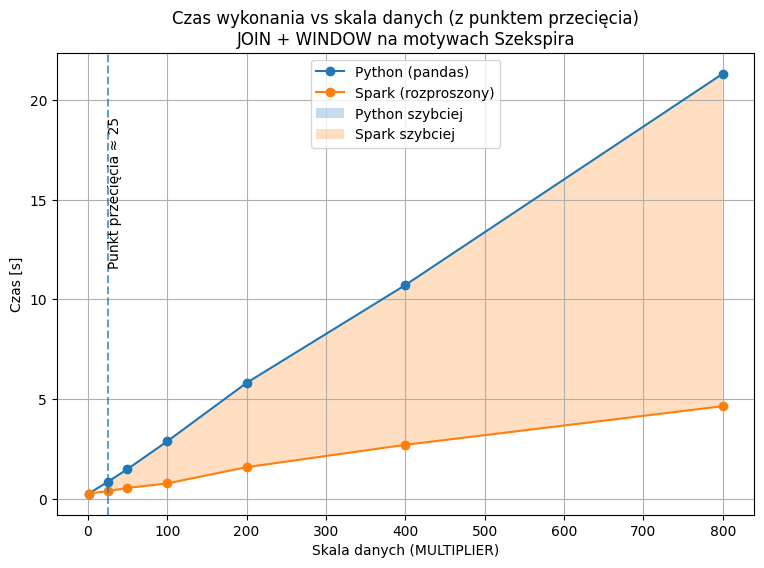

 Dydaktyczna interpretacja:
• Do MULTIPLIER ≈ 25 Python bywa szybszy (niższy narzut, praca w RAM).
• Powyżej tej wartości Spark wygrywa — równoległość + optymalizacja DAG.
• Replikacja w Sparku odbywa się PRZED block_id z przesunięciem indeksu, więc rośnie realna liczba bloków (uczciwa skala).
• Pomiar obejmuje tylko fazę okienkową (JOIN + WINDOW), bez transferu do drivera.
Warning bad data


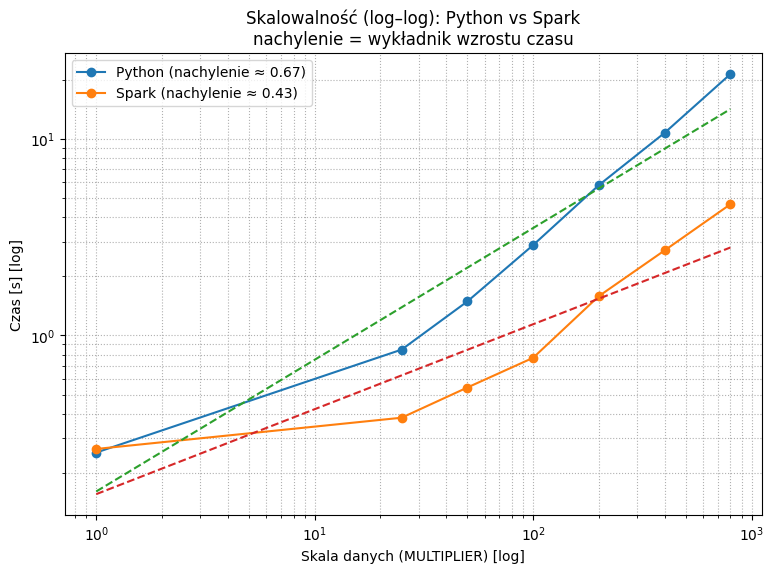

📐 Nachylenia (mniejsze = lepsza skalowalność):
• Python: 0.670
• Spark : 0.432
🔀 Szacowany punkt przecięcia wg trendu: MULTIPLIER ≈ 0.9

Wykres zapisany jako: skalowalnosc_loglog_spark_vs_python.png

🧠 Interpretacja dydaktyczna:
• Nachylenie ~1 oznacza wzrost ~liniowy z rozmiarem danych (typowe dla jednowątkowego Pythona).
• Nachylenie < 1 oznacza wzrost subliniowy (lepsza skalowalność) — zwykle Spark.
• Różnica nachyleń pokazuje, dlaczego przy dużych danych krzywe się rozchodzą na korzyść Sparka.


<Figure size 640x480 with 0 Axes>

In [19]:
# Pelny flow dla daty dla keywords 1
results = benchmark(BLOCK_SIZE, SOURCES, KEYWORDS_1, WINDOW_RADIUS, SCALES)
res_df = pd.DataFrame(results)
intersection = intersection_point(res_df)
summary(intersection=intersection)
scalability_analysis(results)

time.sleep(2)


=== TEST: MULTIPLIER = 1 ===
Python: 0.26s | Spark: 0.27s

=== TEST: MULTIPLIER = 25 ===
Python: 1.02s | Spark: 0.40s

=== TEST: MULTIPLIER = 50 ===
Python: 1.48s | Spark: 0.56s

=== TEST: MULTIPLIER = 100 ===


Python: 2.75s | Spark: 0.81s

=== TEST: MULTIPLIER = 200 ===


Python: 5.41s | Spark: 1.58s

=== TEST: MULTIPLIER = 400 ===


Python: 11.04s | Spark: 2.55s

=== TEST: MULTIPLIER = 800 ===


Python: 21.51s | Spark: 5.60s


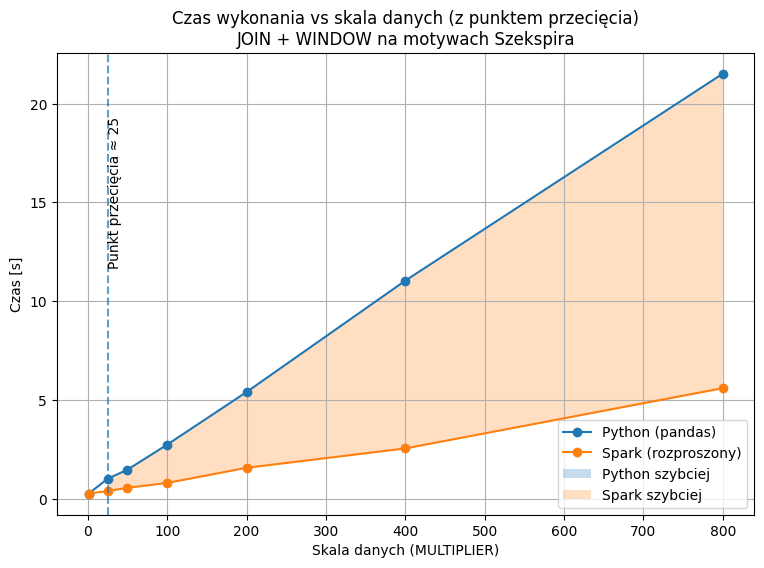

 Dydaktyczna interpretacja:
• Do MULTIPLIER ≈ 25 Python bywa szybszy (niższy narzut, praca w RAM).
• Powyżej tej wartości Spark wygrywa — równoległość + optymalizacja DAG.
• Replikacja w Sparku odbywa się PRZED block_id z przesunięciem indeksu, więc rośnie realna liczba bloków (uczciwa skala).
• Pomiar obejmuje tylko fazę okienkową (JOIN + WINDOW), bez transferu do drivera.
Warning bad data


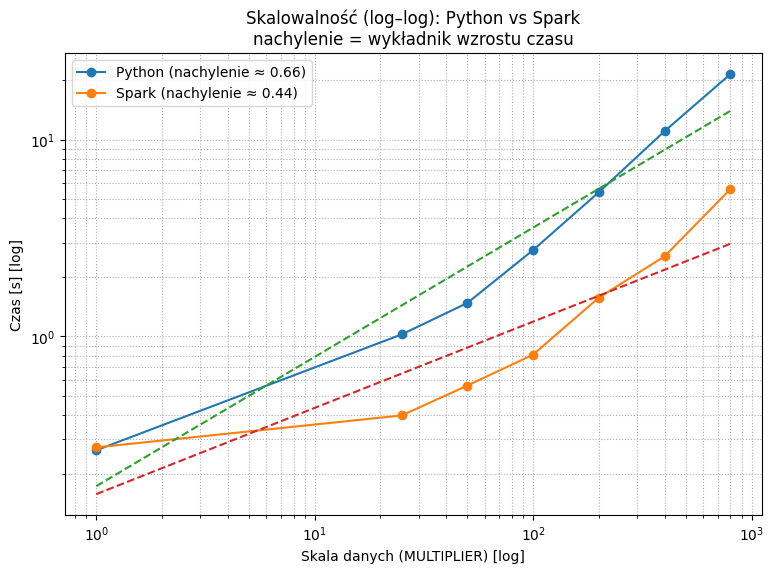

📐 Nachylenia (mniejsze = lepsza skalowalność):
• Python: 0.657
• Spark : 0.438
🔀 Szacowany punkt przecięcia wg trendu: MULTIPLIER ≈ 0.7

Wykres zapisany jako: skalowalnosc_loglog_spark_vs_python.png

🧠 Interpretacja dydaktyczna:
• Nachylenie ~1 oznacza wzrost ~liniowy z rozmiarem danych (typowe dla jednowątkowego Pythona).
• Nachylenie < 1 oznacza wzrost subliniowy (lepsza skalowalność) — zwykle Spark.
• Różnica nachyleń pokazuje, dlaczego przy dużych danych krzywe się rozchodzą na korzyść Sparka.


<Figure size 640x480 with 0 Axes>

In [20]:
# Pelny flow dla daty dla keywords 2
results_2 = benchmark(BLOCK_SIZE, SOURCES, KEYWORDS_2, WINDOW_RADIUS, SCALES)
res_df_2 = pd.DataFrame(results_2)
intersection_2 = intersection_point(res_df_2)
summary(intersection=intersection_2)
scalability_analysis(results_2)

## Wniosek 2: Analiza wplywu keyword set na czasy
+ Wnioski — Keyword Set 1 vs Keyword Set 2:
	1.	Słowa częste → dużo dopasowań → drogi JOIN i GROUP BY.
	2.	Słowa rzadkie → mało dopasowań → mniej danych po JOIN → szybsze wykonanie.
	3.	Koszt operacji okienkowej zależy od liczby wierszy po agregacji, a nie od liczby tokenów.
	4.	Dlatego przy rzadkich słowach pipeline jest lżejszy, a czasy spadają mimo tej samej skali danych.


=== TEST: MULTIPLIER = 1 ===
Python: 0.27s | Spark: 0.26s

=== TEST: MULTIPLIER = 25 ===
Python: 1.07s | Spark: 0.54s

=== TEST: MULTIPLIER = 50 ===


Python: 2.10s | Spark: 0.83s

=== TEST: MULTIPLIER = 100 ===


Python: 3.76s | Spark: 1.03s

=== TEST: MULTIPLIER = 200 ===


Python: 7.55s | Spark: 1.76s

=== TEST: MULTIPLIER = 400 ===


Python: 14.63s | Spark: 5.15s

=== TEST: MULTIPLIER = 800 ===


Python: 29.19s | Spark: 7.89s


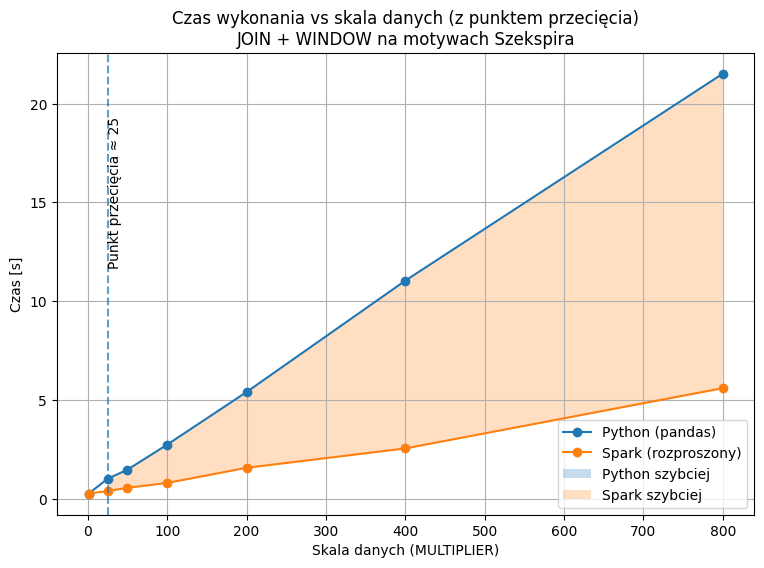

 Dydaktyczna interpretacja:
• Do MULTIPLIER ≈ 25 Python bywa szybszy (niższy narzut, praca w RAM).
• Powyżej tej wartości Spark wygrywa — równoległość + optymalizacja DAG.
• Replikacja w Sparku odbywa się PRZED block_id z przesunięciem indeksu, więc rośnie realna liczba bloków (uczciwa skala).
• Pomiar obejmuje tylko fazę okienkową (JOIN + WINDOW), bez transferu do drivera.
Warning bad data


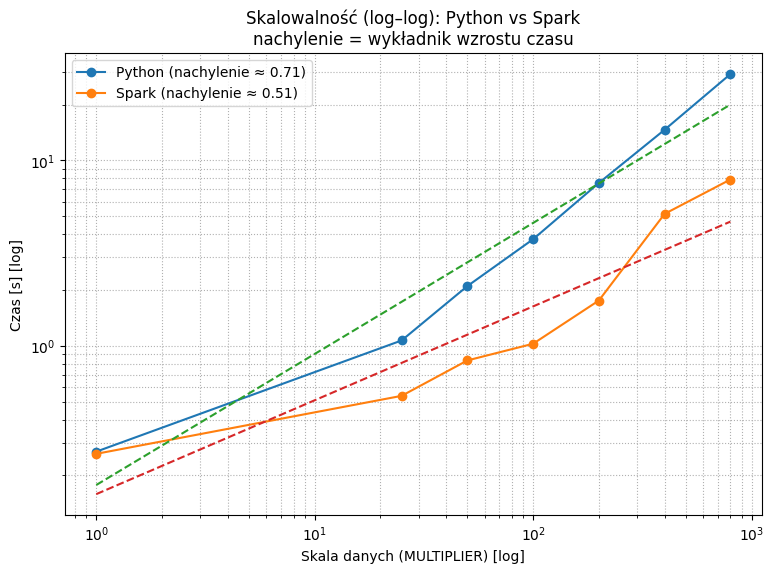

📐 Nachylenia (mniejsze = lepsza skalowalność):
• Python: 0.707
• Spark : 0.506
🔀 Szacowany punkt przecięcia wg trendu: MULTIPLIER ≈ 0.6

Wykres zapisany jako: skalowalnosc_loglog_spark_vs_python.png

🧠 Interpretacja dydaktyczna:
• Nachylenie ~1 oznacza wzrost ~liniowy z rozmiarem danych (typowe dla jednowątkowego Pythona).
• Nachylenie < 1 oznacza wzrost subliniowy (lepsza skalowalność) — zwykle Spark.
• Różnica nachyleń pokazuje, dlaczego przy dużych danych krzywe się rozchodzą na korzyść Sparka.


<Figure size 640x480 with 0 Axes>

In [21]:
# Pelny flow dla daty dla keywords 2 dla batch 50
results_3 = benchmark((BLOCK_SIZE - 100), SOURCES, KEYWORDS_2, WINDOW_RADIUS, SCALES)
res_df_3 = pd.DataFrame(results_2)
intersection_3 = intersection_point(res_df_3)
summary(intersection=intersection_3)
scalability_analysis(results_3)


=== TEST: MULTIPLIER = 1 ===
Python: 0.24s | Spark: 0.26s

=== TEST: MULTIPLIER = 25 ===
Python: 0.74s | Spark: 0.41s

=== TEST: MULTIPLIER = 50 ===
Python: 1.27s | Spark: 0.48s

=== TEST: MULTIPLIER = 100 ===


Python: 2.34s | Spark: 0.78s

=== TEST: MULTIPLIER = 200 ===


Python: 4.42s | Spark: 2.21s

=== TEST: MULTIPLIER = 400 ===


Python: 8.84s | Spark: 2.10s

=== TEST: MULTIPLIER = 800 ===


Python: 17.21s | Spark: 4.17s


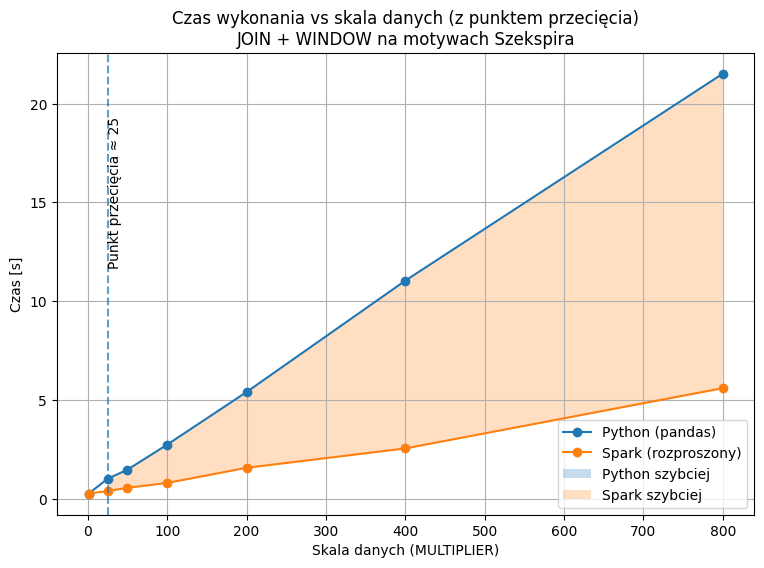

 Dydaktyczna interpretacja:
• Do MULTIPLIER ≈ 25 Python bywa szybszy (niższy narzut, praca w RAM).
• Powyżej tej wartości Spark wygrywa — równoległość + optymalizacja DAG.
• Replikacja w Sparku odbywa się PRZED block_id z przesunięciem indeksu, więc rośnie realna liczba bloków (uczciwa skala).
• Pomiar obejmuje tylko fazę okienkową (JOIN + WINDOW), bez transferu do drivera.
Warning bad data


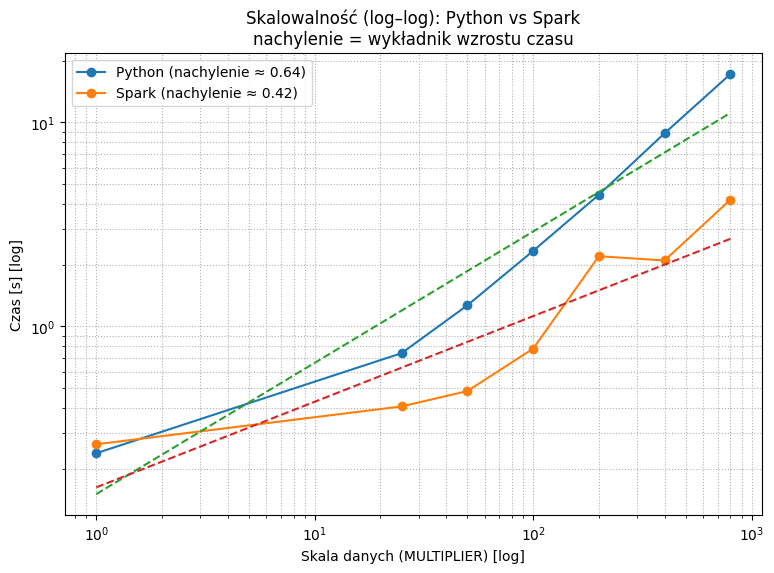

📐 Nachylenia (mniejsze = lepsza skalowalność):
• Python: 0.643
• Spark : 0.419
🔀 Szacowany punkt przecięcia wg trendu: MULTIPLIER ≈ 1.4

Wykres zapisany jako: skalowalnosc_loglog_spark_vs_python.png

🧠 Interpretacja dydaktyczna:
• Nachylenie ~1 oznacza wzrost ~liniowy z rozmiarem danych (typowe dla jednowątkowego Pythona).
• Nachylenie < 1 oznacza wzrost subliniowy (lepsza skalowalność) — zwykle Spark.
• Różnica nachyleń pokazuje, dlaczego przy dużych danych krzywe się rozchodzą na korzyść Sparka.


<Figure size 640x480 with 0 Axes>

In [22]:
# Pelny flow dla daty dla keywords 2 dla batch 500
results_4 = benchmark((BLOCK_SIZE + 350), SOURCES, KEYWORDS_2, WINDOW_RADIUS, SCALES)
res_df_4 = pd.DataFrame(results_2)
intersection_4 = intersection_point(res_df_4)
summary(intersection=intersection_4)
scalability_analysis(results_4)